# Imports


In [13]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import os
import community as community_louvain
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.cm as cm


# Utility Functions

In [14]:
def remove_rows_by_column_value(df, column_name, value_to_remove):
    """
    Remove all rows from a DataFrame where a specific column matches a given value.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column_name (str): The name of the column to filter.
        value_to_remove (str): The value to remove from the column.

    Returns:
        pd.DataFrame: A new DataFrame with the specified rows removed.

    Raises:
        KeyError: If the specified column is not in the DataFrame.
    """
    if column_name not in df.columns:
        raise KeyError(f"Column '{column_name}' not found in DataFrame.")

    filtered_df = df[df[column_name] != value_to_remove].copy()
    return filtered_df

def remove_duplicate_rows(df):
    """
    Remove duplicate rows from a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: A new DataFrame without duplicate rows.
    """
    cleaned_df = df.drop_duplicates().copy()
    return cleaned_df

def sample_dataframe(df, percentage, random_state=None):
    """
    Randomly sample a percentage of rows from a DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        percentage (float): Percentage of rows to sample (between 0 and 100).
        random_state (int, optional): Seed for reproducibility.

    Returns:
        pd.DataFrame: A sampled subset of the original DataFrame.

    Raises:
        ValueError: If percentage is not between 0 and 100.
    """
    if not (0 < percentage <= 100):
        raise ValueError("Percentage must be between 0 and 100.")

    frac = percentage / 100.0
    sampled_df = df.sample(frac=frac, random_state=random_state).copy()
    return sampled_df

def stratified_sample_by_column(df, column, percentage, random_state=None):
    """
    Reduce a DataFrame to a given percentage while preserving the distribution
    of values in a specific column (stratified sampling).

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column (str): Column name to preserve distribution (e.g., "Cuisine").
        percentage (float): Percentage of total rows to keep (0 < percentage <= 100).
        random_state (int, optional): Seed for reproducibility.

    Returns:
        pd.DataFrame: A new stratified-sampled DataFrame.

    Raises:
        ValueError: If percentage is not between 0 and 100.
        KeyError: If the specified column does not exist.
    """
    if not (0 < percentage <= 100):
        raise ValueError("Percentage must be between 0 and 100.")
    if column not in df.columns:
        raise KeyError(f"Column '{column}' not found in DataFrame.")

    sampled_dfs = []
    frac = percentage / 100.0

    for group_value, group_df in df.groupby(column):
        group_sample = group_df.sample(frac=frac, random_state=random_state)
        sampled_dfs.append(group_sample)

    result_df = pd.concat(sampled_dfs).reset_index(drop=True)
    return result_df

def calculate_network_descriptors(G):
    """
    Compute key structural and macroscopic descriptors for the given network.

    Parameters:
        G (networkx.Graph): The input graph.

    Returns:
        dict: A dictionary containing the following metrics:
            - 'nodes': Number of nodes in the network.
            - 'edges': Number of edges in the network.
            - 'self_loops': Number of self-loops.
            - 'multi_edges': Number of multi-edges.
            - 'degree_min': Minimum node degree.
            - 'degree_max': Maximum node degree.
            - 'degree_avg': Average node degree.
            - 'clustering': Average clustering coefficient.
            - 'assortativity': Degree assortativity coefficient.
            - 'avg_path_length': Average shortest path length (largest connected component).
            - 'diameter': Diameter of the largest connected component.
    """
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    degrees = [d for _, d in G.degree()]

    self_loops = nx.number_of_selfloops(G)
    multi_edges = sum(1 for edge in G.edges() if G.number_of_edges(edge[0], edge[1]) > 1)

    largest_cc = max(nx.connected_components(G), key=len)
    g_largest_cc = G.subgraph(largest_cc)

    return {
        'nodes': n_nodes,
        'edges': n_edges,
        'self_loops': self_loops,
        'multi_edges': multi_edges,
        'degree_min': np.min(degrees),
        'degree_max': np.max(degrees),
        'degree_avg': np.mean(degrees),
        'clustering': nx.average_clustering(G),
        'assortativity': nx.degree_assortativity_coefficient(G),
        'avg_path_length': nx.average_shortest_path_length(g_largest_cc),
        'diameter': nx.diameter(g_largest_cc),
    }

def calculate_centralities(G):
    """
    Compute node centrality measures for a single network.

    Parameters:
        G (networkx.Graph): The input graph.

    Returns:
        - dict: A dictionary with centrality measures:
            - 'betweenness': Betweenness centrality for each node.
            - 'degree': Degree centrality for each node.
            - 'eigenvector': Eigenvector centrality for each node.
    """
    return {
        'betweenness': nx.betweenness_centrality(G),
        'degree': dict(G.degree()),
        'eigenvector': nx.eigenvector_centrality(G)
    }

def plot_degree_distribution(degree_sequence, net_name, save=True, show=False, out_dir='report'):
    """
    Plot degree distribution in both linear and logarithmic scales.

    Parameters:
        degree_sequence (list): List of node degrees.
        net_name (str): Network name for title and filename.
        save (bool): If True, saves the plot as PNG in the output directory.
        show (bool): If True, displays the plot.
        out_dir (str): Output directory for saving the plot.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    degree_counts = Counter(degree_sequence)
    min_degree = min(degree_sequence)
    max_degree = max(degree_sequence)

    degree = list(range(min_degree, max_degree + 1))
    degree_count = [degree_counts.get(x, 0) for x in degree]

    # Linear scale
    ax[0].scatter(degree, degree_count, color='blue', label='data')
    ax[0].set_xlabel('$k$', fontsize=14)
    ax[0].set_ylabel('$P(k)$', fontsize=14)
    ax[0].set_title('Linear scale', fontsize=14)
    ax[0].tick_params(axis='both', labelsize=12)

    # Log-log scale
    ax[1].scatter(degree, degree_count, color='red', label='data')
    ax[1].set_xlabel('$k$', fontsize=14)
    ax[1].set_ylabel('$P(k)$', fontsize=14)
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    ax[1].set_title('Logarithmic scale', fontsize=14)
    ax[1].tick_params(axis='both', labelsize=12)

    plt.suptitle(f'Degree Distribution: {net_name}', fontsize=16)
    plt.tight_layout()

    if save:
        os.makedirs(out_dir, exist_ok=True)
        file_path = os.path.join(out_dir, f"{net_name}_degree_distribution.png")
        plt.savefig(file_path, bbox_inches='tight')

    if show:
        plt.show()

    plt.close()

def add_bipartite_nodes_from_dataframe(G, df, column_id, bipartite, prefix):
    """
    Add nodes to a graph from a DataFrame for a bipartite graph construction.

    Parameters:
        G (networkx.Graph): The graph to which nodes are added.
        df (pd.DataFrame): The DataFrame containing node data.
        column_id (str): The name of the column with unique node identifiers.
        bipartite (int): The bipartite set this node belongs to (0 or 1).
        prefix (str): Prefix to prepend to the node ID (e.g., 'R' for recipes, 'I' for ingredients).

    Returns:
        None (the graph is modified in-place).
    """
    if column_id not in df.columns:
        raise KeyError(f"Column '{column_id}' not found in DataFrame.")

    for _, row in df.iterrows():
        node_id = f"{prefix}{row[column_id]}"
        attrs = row.drop(column_id).to_dict()
        attrs['bipartite'] = bipartite
        G.add_node(node_id, **attrs)

def apply_greedy_community_detection(G, weight=None):
    """
    Applies the Greedy Modularity algorithm to the given graph.

    Parameters:
        G (networkx.Graph): The graph on which to run community detection.
        weight (str or None): Edge attribute to use as weight. If None, the graph is unweighted.

    Returns:
        list: A list of sets, where each set contains the nodes in one community.
    """
    return list(greedy_modularity_communities(G, weight=weight))


def detect_communities_louvain(G):
    """
    Apply Louvain algorithm to detect communities in G using NetworkX interface.

    Parameters:
        G (networkx.Graph): Input graph.

    Returns:
        communities (list[set]): Detected communities.
    """
    return list(nx.community.louvain_communities(G))

def add_edges_from_dataframe(G, df, col1, col2, prefix1, prefix2):
    """
    Add edges to a graph from a DataFrame using two columns and respective prefixes.

    Parameters:
        G (networkx.Graph): The graph to which edges are added.
        df (pd.DataFrame): The DataFrame containing edge data.
        col1 (str): Column name for the first node ID (e.g., "Recipe ID").
        col2 (str): Column name for the second node ID (e.g., "Entity ID").
        prefix1 (str): Prefix for nodes from col1 (e.g., "R").
        prefix2 (str): Prefix for nodes from col2 (e.g., "I").

    Returns:
        None (the graph is modified in-place).
    """
    if col1 not in df.columns or col2 not in df.columns:
        raise KeyError(f"Columns '{col1}' and/or '{col2}' not found in DataFrame.")

    for _, row in df.iterrows():
        node1 = f"{prefix1}{row[col1]}"
        node2 = f"{prefix2}{row[col2]}"
        G.add_edge(node1, node2)

# Builder

In [40]:
def build_recipe_ingredient_graph():
    """
    Build a bipartite graph connecting recipes and ingredients.

    Returns:
        networkx.Graph: A bipartite graph with:
            - Recipe nodes prefixed with 'R' and bipartite=0
            - Ingredient nodes prefixed with 'I' and bipartite=1
            - Edges from recipes to their ingredients
    """
    # 1. Carica i DataFrame
    recipes_df = pd.read_csv("./culinaryDB/01_Recipe_Details.csv")
    ingredients_df = pd.read_csv("./culinaryDB/02_Ingredients.csv")
    recipe_ing_df = pd.read_csv("./culinaryDB/04_Recipe-Ingredients_Aliases.csv")


    # 1.1. Prendo solo una percentuale dell'intero DataFrame
    recipes_df = stratified_sample_by_column(recipes_df, column="Cuisine", percentage=0.7, random_state=42)

    print(len(recipes_df))
    # Filtro anche recipe_ing_df in base alle ricette campionate
    recipe_ids_to_keep = set(recipes_df["Recipe ID"])
    recipe_ing_df = recipe_ing_df[recipe_ing_df["Recipe ID"].isin(recipe_ids_to_keep)].copy()

    # 2. Pulizia opzionale
    recipes_df = remove_duplicate_rows(recipes_df)
    recipe_ing_df = remove_duplicate_rows(recipe_ing_df)
    ingredients_df = remove_duplicate_rows(ingredients_df)

    # 2.1 rimozione ingredienti comuni
    ingredients_df = remove_rows_by_column_value(ingredients_df, "Entity ID", "778") # salt
    recipe_ing_df = remove_rows_by_column_value(recipe_ing_df, "Entity ID", "778") # salt

    ingredients_df = remove_rows_by_column_value(ingredients_df, "Entity ID", "781") # sugar
    recipe_ing_df = remove_rows_by_column_value(recipe_ing_df, "Entity ID", "781") # sugar


    # 3. Crea il grafo bipartito
    G = nx.Graph()

    # 4. Aggiungi nodi ricetta
    add_bipartite_nodes_from_dataframe(G, recipes_df, column_id="Recipe ID", bipartite=0, prefix="R")

    # 5. Aggiungi nodi ingrediente
    add_bipartite_nodes_from_dataframe(G, ingredients_df, column_id="Entity ID", bipartite=1, prefix="I")

    # 6. Aggiungi archi ricetta–ingrediente
    add_edges_from_dataframe(G, recipe_ing_df, col1="Recipe ID", col2="Entity ID", prefix1="R", prefix2="I")

    return G

def build_recipe_cooccurrence_graph(G_bipartite):
    """
    Create a recipe-recipe co-occurrence graph based on shared ingredients.

    Parameters:
        G_bipartite (networkx.Graph): A bipartite graph of recipes and ingredients.

    Returns:
        networkx.Graph: A weighted, undirected graph where:
            - Nodes are recipes (bipartite=0).
            - Edges exist if recipes share at least one ingredient.
            - Each edge has:
                - 'weight': number of shared ingredients
                - 'shared_ingredients': list of shared ingredient node IDs
    """
    # 1. Estrai i nodi delle ricette
    recipe_nodes = [n for n, d in G_bipartite.nodes(data=True) if d.get("bipartite") == 0]

    # 2. Crea grafo vuoto
    G_cooc = nx.Graph()

    # 3. Per ogni coppia di ricette, controlla gli ingredienti in comune
    for i, r1 in enumerate(recipe_nodes):
        ingredients_r1 = set(G_bipartite.neighbors(r1))
        for r2 in recipe_nodes[i+1:]:
            ingredients_r2 = set(G_bipartite.neighbors(r2))
            shared = ingredients_r1 & ingredients_r2
            if shared:
                G_cooc.add_edge(r1, r2,
                                weight=len(shared),
                                shared_ingredients=sorted(shared))

    return G_cooc

def visualize_graph_with_clusters(G, title="Recipe Co-occurrence Graph", node_size=100):
    """
    Visualize a recipe co-occurrence graph with clusters (communities) highlighted by color.

    Parameters:
        G (networkx.Graph): The graph to visualize.
        title (str): Title of the plot.
        node_size (int): Size of each node in the plot.
    """
    # 1. Community detection (Greedy Modularity)
    communities = list(greedy_modularity_communities(G))

    # 2. Crea una mappa nodo → comunità
    node_to_community = {}
    for i, comm in enumerate(communities):
        for node in comm:
            node_to_community[node] = i

    # 3. Layout
    pos = nx.spring_layout(G, seed=42)

    # 4. Colori per comunità
    colors = cm.get_cmap("tab10", len(communities))

    # 5. Disegna nodi
    for i, comm in enumerate(communities):
        nx.draw_networkx_nodes(G, pos,
                               nodelist=list(comm),
                               node_color=[colors(i)],
                               node_size=node_size,
                               label=f"Cluster {i+1}")

    # 6. Disegna archi
    nx.draw_networkx_edges(G, pos, alpha=0.3)

    # 7. Titolo e legenda
    plt.title(title, fontsize=14)
    plt.legend(scatterpoints=1)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

def get_community_cuisine_distribution(G_bipartite, communities):
    """
    Return a summary of Cuisine distributions per community.

    Parameters:
        G_bipartite (networkx.Graph): Original graph with recipe attributes.
        communities (list of sets): Recipe communities from the co-occurrence graph.

    Returns:
        list of pd.DataFrame: One dataframe per community showing cuisine counts and percentages.
    """
    summaries = []

    for i, comm in enumerate(communities):
        recipe_nodes = [n for n in comm if n.startswith("R")]
        cuisines = [G_bipartite.nodes[n].get("Cuisine", "Unknown") for n in recipe_nodes]
        count = Counter(cuisines)
        total = sum(count.values())
        df = pd.DataFrame({
            "Cuisine": list(count.keys()),
            "Count": list(count.values())
        })
        df["%"] = 100 * df["Count"] / total
        df = df.sort_values("Count", ascending=False).reset_index(drop=True)
        summaries.append(df)

    return summaries

def get_community_ingredient_distribution(G_bipartite, communities, ingredients_df):
    """
    Return ingredient usage summaries (with names and categories) per recipe community.

    Parameters:
        G_bipartite (networkx.Graph): Bipartite graph with recipes and ingredients.
        communities (list of sets): Sets of recipe nodes.
        ingredients_df (pd.DataFrame): Must contain 'Entity ID', 'Aliased Ingredient Name', and 'Category'.

    Returns:
        list of pd.DataFrame: One DataFrame per community with:
            - Ingredient ID
            - Name
            - Category
            - Count
            - %
    """
    ingredients_df = ingredients_df.copy()
    ingredients_df["Ingredient ID"] = ingredients_df["Entity ID"].apply(lambda x: f"I{x}")

    summaries = []

    for i, comm in enumerate(communities):
        recipe_nodes = [n for n in comm if n.startswith("R")]

        # Trova tutti gli ingredienti usati nelle ricette di questa community
        ingredient_ids = []
        for recipe in recipe_nodes:
            ingredient_ids.extend(n for n in G_bipartite.neighbors(recipe) if n.startswith("I"))

        count = Counter(ingredient_ids)
        total = sum(count.values())

        df = pd.DataFrame({
            "Ingredient ID": list(count.keys()),
            "Count": list(count.values())
        })
        df["%"] = 100 * df["Count"] / total

        # Aggiungi nome e categoria
        df = df.merge(ingredients_df[["Ingredient ID", "Aliased Ingredient Name", "Category"]],
                      on="Ingredient ID", how="left")

        df = df.sort_values("Count", ascending=False).reset_index(drop=True)
        summaries.append(df)

    return summaries

# Driver

In [43]:
G_bipartite = build_recipe_ingredient_graph()
G = build_recipe_cooccurrence_graph(G_bipartite)
communities = apply_greedy_community_detection(G)
print(f"Trovate {len(communities)} community")

cuisine_distributions = get_community_cuisine_distribution(G_bipartite, communities)

# Mostra tutte le community
for i, df in enumerate(cuisine_distributions):
    print(f"\n🍲 Community {i+1} – {df['Count'].sum()} ricette")
    display(df)

ingredients_df = pd.read_csv("./culinaryDB/02_Ingredients.csv")

# Step 4: ottieni le distribuzioni per ogni community
ingredient_distributions = get_community_ingredient_distribution(G_bipartite, communities, ingredients_df)

# Step 5: visualizza la prima
print("Community 1 – Ingredienti principali:")
display(ingredient_distributions[0].head(50))

print("Community 2 – Ingredienti principali:")
display(ingredient_distributions[1].head(50))

322
Trovate 2 community

🍲 Community 1 – 169 ricette


,Cuisine,Count,%
0,Italy,44,26.035503
1,USA,42,24.852071
2,Indian Subcontinent,18,10.650888
3,Mexico,14,8.284024
4,France,7,4.142012
5,Caribbean,6,3.550296
6,China,5,2.958580
7,Spain,5,2.958580
8,Middle East,4,2.366864
9,South East Asia,4,2.366864



🍲 Community 2 – 153 ricette


,Cuisine,Count,%
0,USA,71,46.405229
1,France,12,7.843137
2,Indian Subcontinent,10,6.535948
3,Italy,9,5.882353
4,Mexico,8,5.228758
5,Canada,6,3.921569
6,British Isles,5,3.267974
7,Eastern Europe,4,2.614379
8,Japan,3,1.960784
9,Middle East,3,1.960784


Community 1 – Ingredienti principali:


,Ingredient ID,Count,%,Aliased Ingredient Name,Category
0,I259,99,5.903399,Garlic,Herb
1,I339,94,5.605247,Pepper,Spice
2,I307,89,5.307096,Olive,Plant
3,I348,76,4.531902,Onion,Vegetable
4,I778,67,3.995230,Salt,Additive
5,I364,56,3.339296,Tomato,Vegetable
6,I362,40,2.385212,Capsicum,Vegetable
7,I272,37,2.206321,Chicken,Meat
8,I992,35,2.087060,Cayenne,Spice
9,I338,28,1.669648,Parsley,Spice


Community 2 – Ingredienti principali:


,Ingredient ID,Count,%,Aliased Ingredient Name,Category
0,I781,85,6.651017,Sugar,Additive
1,I778,73,5.712050,Salt,Additive
2,I60,72,5.633803,Butter,Dairy
3,I0,64,5.007825,Egg,Meat
4,I2056,51,3.990610,NaN,NaN
5,I794,48,3.755869,Water,Additive
6,I780,35,2.738654,Cream,Dairy
7,I88,35,2.738654,Milk,Dairy
8,I339,27,2.112676,Pepper,Spice
9,I348,25,1.956182,Onion,Vegetable


C:\Users\Pasquale Raimo\AppData\Local\Temp\ipykernel_17016\4263313727.py:108: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab10", len(communities))


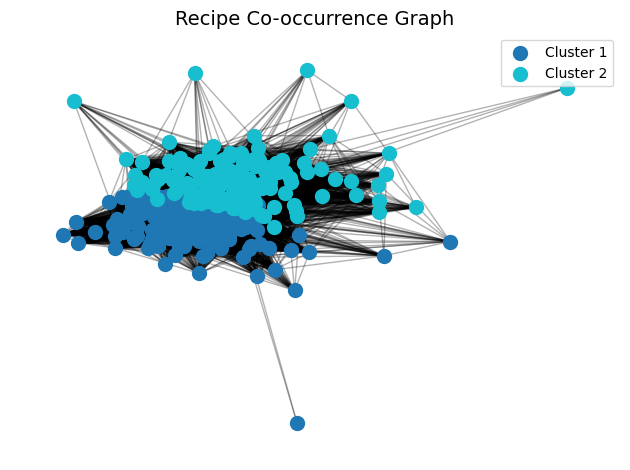

In [27]:
visualize_graph_with_clusters(G)

In [44]:
G_sub = G.subgraph(communities[0]).copy()
sub_clusters = apply_greedy_community_detection(G_sub, weight="weight")


print(f"Trovate {len(communities)} community")

cuisine_distributions = get_community_cuisine_distribution(G_bipartite, sub_clusters)

# Mostra tutte le community
for i, df in enumerate(cuisine_distributions):
    print(f"\n🍲 Community {i+1} – {df['Count'].sum()} ricette")
    display(df)

ingredients_df = pd.read_csv("./culinaryDB/02_Ingredients.csv")

# Step 4: ottieni le distribuzioni per ogni community
ingredient_distributions = get_community_ingredient_distribution(G_bipartite, sub_clusters, ingredients_df)

# Step 5: visualizza la prima
print("Community 1 – Ingredienti principali:")
display(ingredient_distributions[0].head(50))

print("Community 2 – Ingredienti principali:")
display(ingredient_distributions[1].head(50))


Trovate 2 community

🍲 Community 1 – 86 ricette


,Cuisine,Count,%
0,USA,23,26.744186
1,Indian Subcontinent,18,20.930233
2,Mexico,7,8.139535
3,Caribbean,5,5.813953
4,China,5,5.813953
5,Italy,4,4.651163
6,British Isles,3,3.488372
7,Africa,3,3.488372
8,France,3,3.488372
9,Middle East,3,3.488372



🍲 Community 2 – 83 ricette


,Cuisine,Count,%
0,Italy,40,48.192771
1,USA,19,22.891566
2,Mexico,7,8.433735
3,Spain,5,6.024096
4,France,4,4.819277
5,Greece,3,3.614458
6,Australia & NZ,1,1.204819
7,Middle East,1,1.204819
8,Canada,1,1.204819
9,South East Asia,1,1.204819


Community 1 – Ingredienti principali:


,Ingredient ID,Count,%,Aliased Ingredient Name,Category
0,I259,52,5.790646,Garlic,Herb
1,I348,48,5.345212,Onion,Vegetable
2,I339,48,5.345212,Pepper,Spice
3,I778,41,4.565702,Salt,Additive
4,I364,28,3.118040,Tomato,Vegetable
5,I362,27,3.006682,Capsicum,Vegetable
6,I272,26,2.895323,Chicken,Meat
7,I2089,25,2.783964,NaN,NaN
8,I992,24,2.672606,Cayenne,Spice
9,I254,24,2.672606,Coriander,Herb


Community 2 – Ingredienti principali:


,Ingredient ID,Count,%,Aliased Ingredient Name,Category
0,I307,77,9.884467,Olive,Plant
1,I259,47,6.033376,Garlic,Herb
2,I339,46,5.905006,Pepper,Spice
3,I348,28,3.594352,Onion,Vegetable
4,I364,28,3.594352,Tomato,Vegetable
5,I778,26,3.337612,Salt,Additive
6,I338,22,2.824134,Parsley,Spice
7,I322,21,2.695764,Vinegar,Plant
8,I78,15,1.925546,Parmesan Cheese,Dairy
9,I337,15,1.925546,Oregano,Spice
